In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

sns.set_theme(style="ticks")

In [2]:
#Veri kümelerini hazırlama
path = os.path.join(r"C:\Software\bloodcells_dataset")

#Modelin eğitimi için kullanılacak bazı sabit değerleri tanımlama
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
dataset, test_dataset = keras.utils.image_dataset_from_directory(directory=path,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="int",
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 shuffle=True,
                                                                 seed=42)

#Sınıf isimlerini getirme
class_names = dataset.class_names
print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


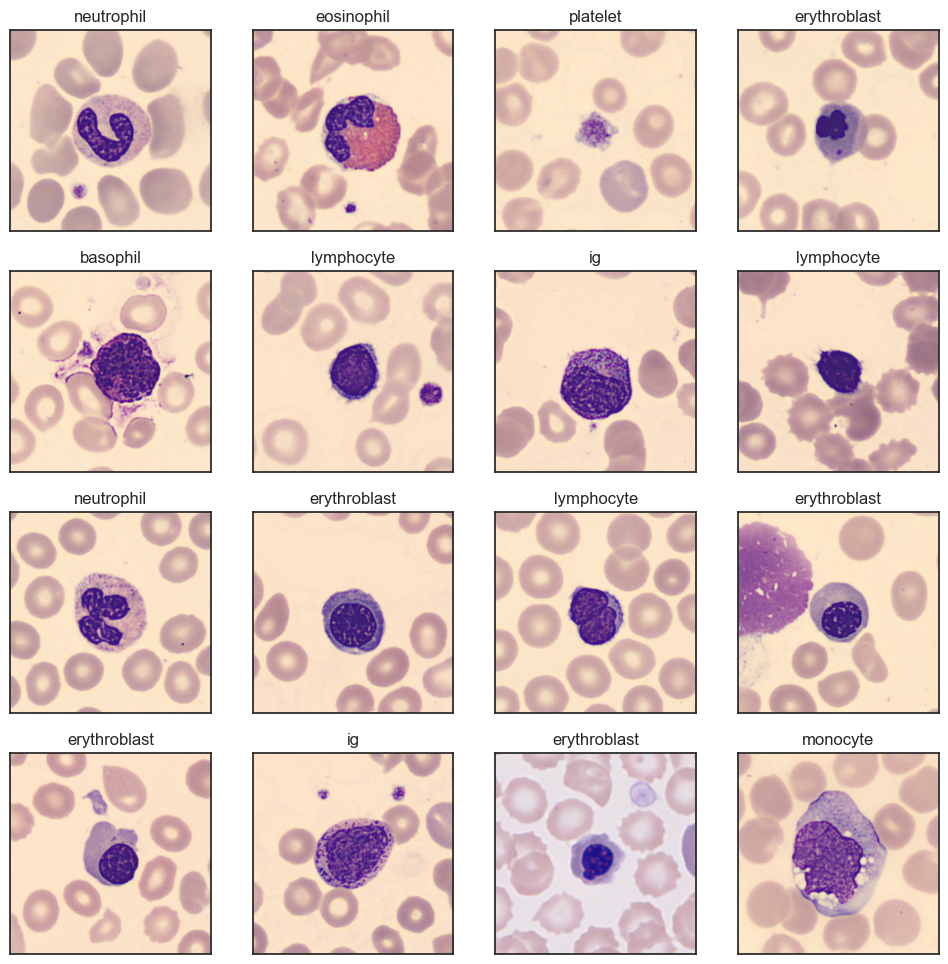

In [3]:
#veri kümesinden örnek alınmış 16 görüntü
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(16):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))

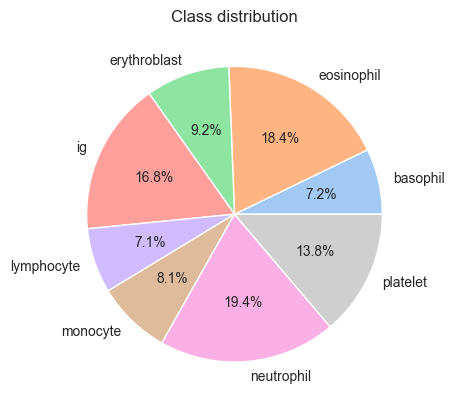

In [4]:
#Etiket dağılımını grafikte gösterme(pasta grafiği)
labels = np.concatenate([label for image, label in dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.show()

In [5]:
# Veri kümesini eğitim ve doğrulama setine ayırma 
num_elements = len(dataset)
train_size = int(0.8 * num_elements)
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# uzunlukları kontrol etme 
len(train_dataset), len(val_dataset), len(test_dataset)

(342, 86, 107)

In [6]:
# Formatı kontrol etme
# Görüntünün boyutlarını kontrol etme
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [7]:
# Piksel yoğunluklarını kontrol etme
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image)) # tüm görüntülerdeki en yüksek pixel değeri
  print(tf.reduce_min(image)) # tüm görüntülerdeki en düşük pixel değeri

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(3.4720578, shape=(), dtype=float32)


In [8]:
lab_book = {} 

# early stopping callback oluşturma
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [9]:
name = "Model"

# modeli oluşturma
tf.random.set_seed(42)
model = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model.summary()

# modeli derleme işlemi
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# modeli eğitme
history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# modelin doğruluk oranlarını kaydetme
train_accuracy = model.evaluate(train_dataset)[1]
val_accuracy = model.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.4628 - loss: 15.6903 - val_accuracy: 0.8110 - val_loss: 0.6007
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.8135 - loss: 0.5377 - val_accuracy: 0.8355 - val_loss: 0.4856
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.8855 - loss: 0.3463 - val_accuracy: 0.8623 - val_loss: 0.4269
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9253 - loss: 0.2374 - val_accuracy: 0.8740 - val_loss: 0.3954
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9505 - loss: 0.1766 - val_accuracy: 0.8579 - val_loss: 0.4497
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9655 - loss: 0.1300 - val_accuracy: 0.8593 - val_loss: 0.4841
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.9745 - loss: 0.1008 - val_accuracy: 0.8700 - val_loss: 0.4473
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9802 - loss: 

In [10]:
# veri artırma katmanlarını ayarlama
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.4)
    ])

In [11]:
# modelin test setinin doğruluğunun tahmin edilmesi
test_scores = {}
test_accuracy = model.evaluate(test_dataset)[1]
test_scores["Model"] = test_accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8620 - loss: 0.4046


In [12]:
y_pred = []
y_pred_proba = []
y_true = []


# veri kümesi üzerinde yineleme işlemi
for image_batch, label_batch in test_dataset:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))


correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

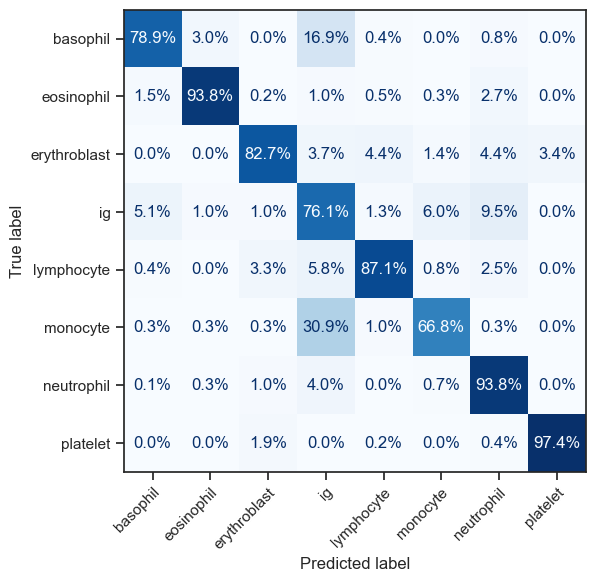

In [13]:
# modelin confusion matrisini gösterme
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

In [14]:
model.save(r"C:\Users\Gül\PycharmProjects\notebooks\normal_model.keras")